In [172]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import StandardScaler
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt

df = pd.read_csv("../data/merged_data.csv", parse_dates=["datetime"])
df = df.sort_values("datetime")
df["hour"] = df["datetime"].dt.hour
df["is_daytime"] = ((df["hour"] >= 7) & (df["hour"] < 19)).astype(int)

df = df.drop(columns=["hour"])

df["sin_hour"] = np.sin(2 * np.pi * df["datetime"].dt.hour / 24)
df["cos_hour"] = np.cos(2 * np.pi * df["datetime"].dt.hour / 24)
df["price_lag_1h"] = df["price_EUR_MWh"].shift(1)

df = df.dropna()

features = [
    "temperature_2m", "wind_speed_180m", "wind_speed_120m", "direct_radiation",
    "quantity_biomass", "quantity_fossil_gas", "quantity_fossil_hard_coal",
    "quantity_hydro_run_of_river", "quantity_nuclear", "quantity_solar",
    "quantity_waste", "quantity_wind_offshore", "quantity_wind_onshore",
    "quantity_other", "price_lag_1h", "is_daytime", "sin_hour", "cos_hour", "quantity_MW"
]
target = "price_EUR_MWh"

scaler_x = StandardScaler()
scaler_y = StandardScaler()

X = scaler_x.fit_transform(df[features])
y = scaler_y.fit_transform(df[[target]])


In [173]:
class TimeSeriesDataset(Dataset):
    """
    Custom Dataset for time series data with fixed sequence length.
    """
    def __init__(self, X, y, seq_len):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)
        self.seq_len = seq_len

    def __len__(self):
        return len(self.X) - self.seq_len

    def __getitem__(self, idx):
        return (
            self.X[idx:idx+self.seq_len],
            self.y[idx+self.seq_len]
        )

class DSSM(nn.Module):
    """
    Deep Structured State Model (DSSM) for time series forecasting.
    This model uses a GRU for state representation and a feedforward network for observation modeling.
    """
    def __init__(self, input_dim, state_dim, hidden_dim):
        super().__init__()
        self.rnn = nn.GRU(input_dim, state_dim, batch_first=True, num_layers=2, dropout=0.15 )
        self.obs_model = nn.Sequential(
            nn.Linear(state_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 1)
        )


    def forward(self, x):
        state_seq, _ = self.rnn(x)
        output = self.obs_model(state_seq[:, -1, :])
        return output.squeeze(-1)

In [174]:
# Splitting the dataset into training and validation sets
# Assuming the data is hourly and we want to validate on the last 30 days
sequence_length = 24 # 24 hours = 1 day
val_days = 30
val_size = val_days * 24

train_X = X[:-val_size]
train_y = y[:-val_size]
val_X = X[-val_size - sequence_length:]
val_y = y[-val_size - sequence_length:]

train_dataset = TimeSeriesDataset(train_X, train_y, sequence_length)
val_dataset = TimeSeriesDataset(val_X, val_y, sequence_length)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# Model, optimizer, and loss function
model = DSSM(input_dim=X.shape[1], state_dim=64, hidden_dim=64)
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.SmoothL1Loss()

# Training the model
n_epochs = 30
model.train()
for epoch in range(n_epochs):
    epoch_loss = 0
    for x, t in train_loader:
        optimizer.zero_grad()
        preds = model(x)
        loss = criterion(preds, t.squeeze(-1))
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

    # Validation
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for x, t in val_loader:
            preds = model(x)
            loss = criterion(preds, t.squeeze(-1))
            val_loss += loss.item()
    model.train()

    print(f"Epoch {epoch+1}, Train Loss: {epoch_loss/len(train_loader):.4f}, Val Loss: {val_loss/len(val_loader):.4f}")

Epoch 1, Train Loss: 0.1446, Val Loss: 0.0279
Epoch 2, Train Loss: 0.0695, Val Loss: 0.0247
Epoch 3, Train Loss: 0.0482, Val Loss: 0.0204
Epoch 4, Train Loss: 0.0408, Val Loss: 0.0186
Epoch 5, Train Loss: 0.0384, Val Loss: 0.0186
Epoch 6, Train Loss: 0.0372, Val Loss: 0.0184
Epoch 7, Train Loss: 0.0366, Val Loss: 0.0184
Epoch 8, Train Loss: 0.0367, Val Loss: 0.0181
Epoch 9, Train Loss: 0.0360, Val Loss: 0.0192
Epoch 10, Train Loss: 0.0360, Val Loss: 0.0195
Epoch 11, Train Loss: 0.0368, Val Loss: 0.0192
Epoch 12, Train Loss: 0.0354, Val Loss: 0.0187
Epoch 13, Train Loss: 0.0358, Val Loss: 0.0196
Epoch 14, Train Loss: 0.0372, Val Loss: 0.0196
Epoch 15, Train Loss: 0.0371, Val Loss: 0.0207
Epoch 16, Train Loss: 0.0397, Val Loss: 0.0202
Epoch 17, Train Loss: 0.0395, Val Loss: 0.0212
Epoch 18, Train Loss: 0.0396, Val Loss: 0.0229
Epoch 19, Train Loss: 0.0385, Val Loss: 0.0221
Epoch 20, Train Loss: 0.0370, Val Loss: 0.0215
Epoch 21, Train Loss: 0.0360, Val Loss: 0.0227
Epoch 22, Train Loss: 

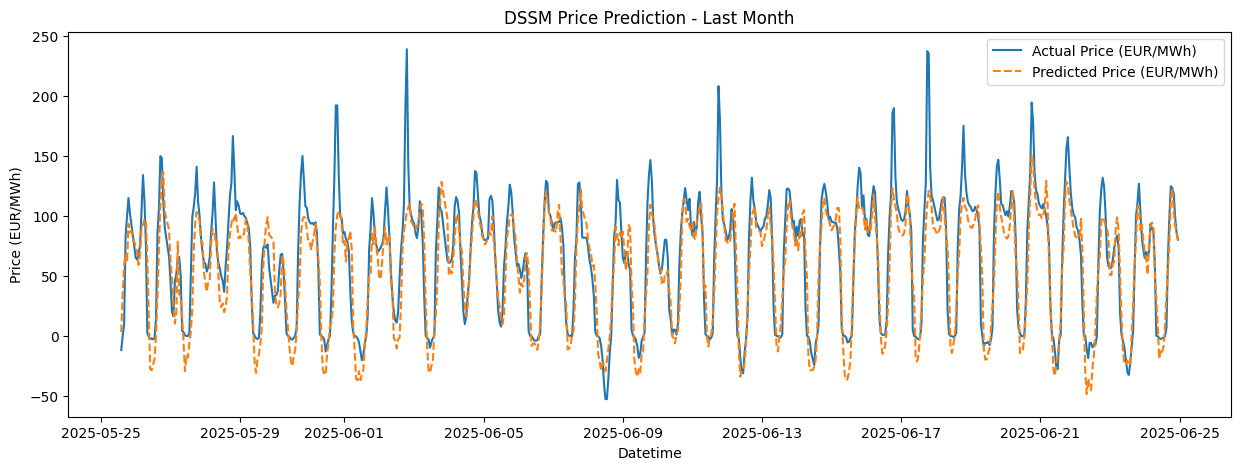

In [175]:
# Evaluation on the last month
model.eval()
all_preds = []
all_actuals = []
with torch.no_grad():
    for x, t in val_loader:
        preds = model(x)
        all_preds.append(preds.numpy())
        all_actuals.append(t.squeeze(-1).numpy())

preds_flat = np.concatenate(all_preds)
actuals_flat = np.concatenate(all_actuals)

preds_inverse = scaler_y.inverse_transform(preds_flat.reshape(-1, 1)).flatten()
actuals_inverse = scaler_y.inverse_transform(actuals_flat.reshape(-1, 1)).flatten()

# Plotting the results for the last month
val_datetimes = df["datetime"].iloc[-val_size:].reset_index(drop=True)

plt.figure(figsize=(15, 5))
plt.plot(val_datetimes, actuals_inverse, label="Actual Price (EUR/MWh)")
plt.plot(val_datetimes, preds_inverse, label="Predicted Price (EUR/MWh)", linestyle="--")
plt.title("DSSM Price Prediction - Last Month")
plt.xlabel("Datetime")
plt.ylabel("Price (EUR/MWh)")
plt.legend()
plt.show()

In [176]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

mse = mean_squared_error(actuals_inverse, preds_inverse)
mae = mean_absolute_error(actuals_inverse, preds_inverse)

denom = (np.abs(actuals_inverse) + np.abs(preds_inverse)) / 2
non_zero_mask = denom != 0
smape = np.mean(np.abs(actuals_inverse - preds_inverse)[non_zero_mask] / denom[non_zero_mask]) * 100

print(f"Validation Set Metrics:")
print(f"MSE: {mse:.2f}")
print(f"MAE: {mae:.2f}")


Validation Set Metrics:
MSE: 597.09
MAE: 18.17


/var/folders/vg/2mjpcbv55m966znhbf9c5k580000gn/T/ipykernel_63274/2702889308.py:73: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  forecast_datetimes = pd.date_range(


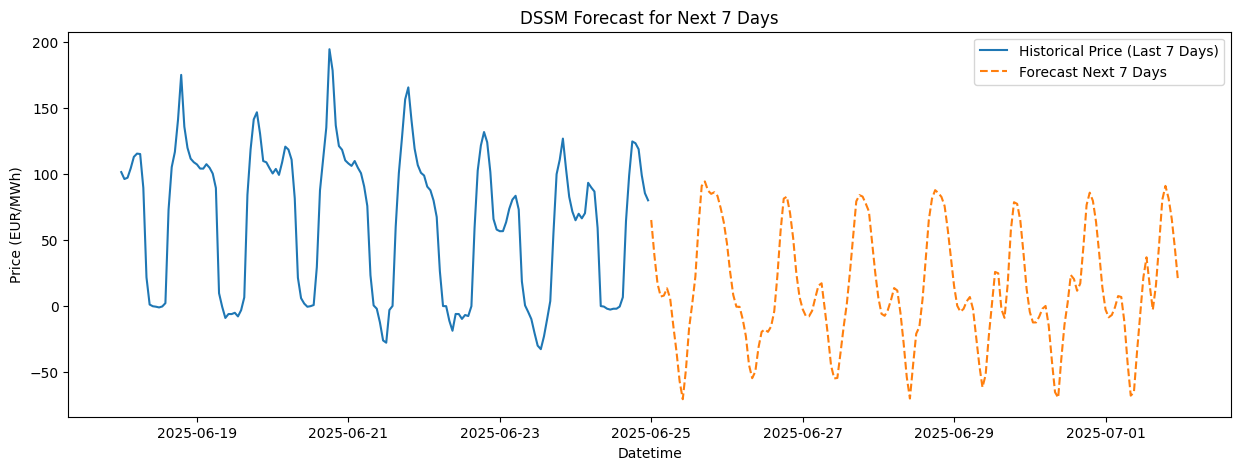

In [186]:
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt

forecast_horizon = 168  # 7 days
sequence_length = 168

# Load weather forecast
weather_df = pd.read_csv("../data/weather_forecast.csv", parse_dates=["datetime"])
weather_df = weather_df.sort_values("datetime").reset_index(drop=True)

# Optional: Scale weather columns now if your model expects scaled weather inputs
weather_features = ["temperature_2m", "wind_speed_180m", "wind_speed_120m", "direct_radiation"]
scaler_weather = StandardScaler()
scaler_weather.fit(df[weather_features])  # Fit only on weather columns
# Scale weather forecast
weather_df[weather_features] = scaler_weather.transform(weather_df[weather_features])

# Prepare latest known features
latest_features = df[features].iloc[-sequence_length:].copy()
latest_scaled = scaler_x.transform(latest_features)

input_seq = torch.tensor(latest_scaled, dtype=torch.float32).unsqueeze(0)
current_seq = input_seq.clone()

forecast_scaled = []
forecast_unscaled = []

for i in range(forecast_horizon):
    model.eval()
    with torch.no_grad():
        pred_scaled = model(current_seq).item()  # Model predicts scaled price
        forecast_scaled.append(pred_scaled)

    pred_unscaled = scaler_y.inverse_transform(np.array([[pred_scaled]]))[0, 0]
    forecast_unscaled.append(pred_unscaled)

    shifted_seq = current_seq[:, 1:, :].squeeze(0).numpy()
    next_feature = shifted_seq[-1].copy()

    # Update lag price feature with scaled prediction (model output already scaled)
    idx_lag = features.index('price_lag_1h')
    next_feature[idx_lag] = pred_scaled

    # Generate new datetime
    new_datetime = df["datetime"].iloc[-1] + pd.Timedelta(hours=i + 1)

    # Update time features
    idx_day = features.index('is_daytime')
    next_feature[idx_day] = 1 if 6 <= new_datetime.hour < 20 else 0

    idx_sin = features.index('sin_hour')
    idx_cos = features.index('cos_hour')
    next_feature[idx_sin] = np.sin(2 * np.pi * new_datetime.hour / 24)
    next_feature[idx_cos] = np.cos(2 * np.pi * new_datetime.hour / 24)

    # Inject weather forecast if available
    weather_row = weather_df.loc[weather_df["datetime"] == new_datetime]
    if not weather_row.empty:
        for w_feat in weather_features:
            if w_feat in features:
                idx_w = features.index(w_feat)
                next_feature[idx_w] = weather_row.iloc[0][w_feat]
    else:
        print(f"No weather forecast for {new_datetime}, keeping last known values.")

    # Build new input sequence
    new_seq = np.vstack([shifted_seq, next_feature])
    current_seq = torch.tensor(new_seq, dtype=torch.float32).unsqueeze(0)

# Create forecast datetimes
forecast_datetimes = pd.date_range(
    start=df["datetime"].iloc[-1] + pd.Timedelta(hours=1),
    periods=forecast_horizon,
    freq="H"
)

# Plot historical + forecast
plt.figure(figsize=(15, 5))
plt.plot(df["datetime"].iloc[-7*24:], df["price_EUR_MWh"].iloc[-7*24:], label="Historical Price (Last 7 Days)")
plt.plot(forecast_datetimes, forecast_unscaled, label="Forecast Next 7 Days", linestyle="--")
plt.title("DSSM Forecast for Next 7 Days")
plt.xlabel("Datetime")
plt.ylabel("Price (EUR/MWh)")
plt.legend()
plt.show()


In [178]:
weather_df

,datetime,temperature_2m,wind_speed_180m,wind_speed_120m,direct_radiation
0,2025-06-30 00:00:00+00:00,15.669499,10.440001,23.039999,0.000000
1,2025-06-30 01:00:00+00:00,14.619500,9.360000,23.400000,0.000000
2,2025-06-30 02:00:00+00:00,14.019500,8.280000,23.400000,0.000000
3,2025-06-30 03:00:00+00:00,13.769500,9.720000,27.000000,0.000000
4,2025-06-30 04:00:00+00:00,13.419499,9.000000,27.359999,0.290586
...,...,...,...,...,...
67,2025-07-02 19:00:00+00:00,19.119501,15.119999,25.560000,0.000000
68,2025-07-02 20:00:00+00:00,18.069500,18.359999,28.440000,0.000000
69,2025-07-02 21:00:00+00:00,17.469501,20.880001,32.760002,0.000000
70,2025-07-02 22:00:00+00:00,17.219501,21.960000,34.920000,0.000000


/var/folders/vg/2mjpcbv55m966znhbf9c5k580000gn/T/ipykernel_63274/1797958823.py:34: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  forecast_datetimes = pd.date_range(start=last_datetime + pd.Timedelta(hours=1), periods=sequence_length, freq="H")


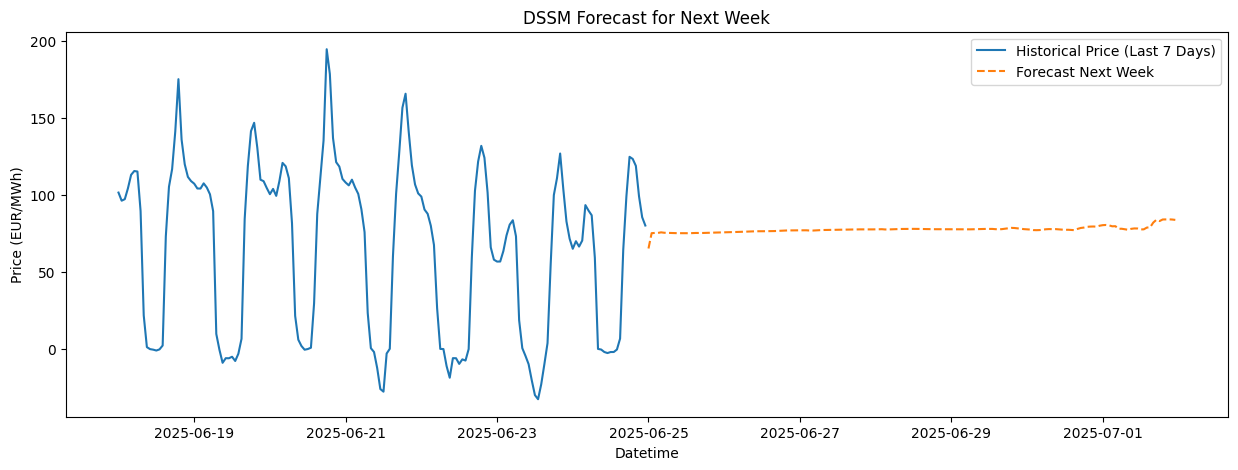

In [181]:
# Forecasting for the next 24 hours
sequence_length = 168

latest_features = df[features].iloc[-sequence_length:]
latest_scaled = scaler_x.transform(latest_features)

input_seq = torch.tensor(latest_scaled, dtype=torch.float32).unsqueeze(0) # Converting to tensor

model.eval()
forecast = []
current_seq = input_seq.clone()

with torch.no_grad():
    for _ in range(sequence_length):
        pred = model(current_seq).item()
        forecast.append(pred)

        # Shifting sequence and append new prediction as placeholder for next hour

        # Shift sequence left, drop first time step
        shifted_seq = current_seq[:, 1:, :].squeeze(0).numpy()
        next_features = latest_scaled[-1]  # Using last known features as placeholder

        # Append to shifted sequence
        new_seq = np.vstack([shifted_seq, next_features])

        current_seq = torch.tensor(new_seq, dtype=torch.float32).unsqueeze(0)

# Inverse transform the forecasted values
forecast_inverse = scaler_y.inverse_transform(np.array(forecast).reshape(-1, 1)).flatten()

# Generate forecast datetimes
last_datetime = df["datetime"].iloc[-1]
forecast_datetimes = pd.date_range(start=last_datetime + pd.Timedelta(hours=1), periods=sequence_length, freq="H")

# Plotting the forecast for the next 24 hours
plt.figure(figsize=(15, 5))
plt.plot(df["datetime"].iloc[-7*24:], df["price_EUR_MWh"].iloc[-7*24:], label="Historical Price (Last 7 Days)")
plt.plot(forecast_datetimes, forecast_inverse, label="Forecast Next Week", linestyle="--")
plt.title("DSSM Forecast for Next Week")
plt.xlabel("Datetime")
plt.ylabel("Price (EUR/MWh)")
plt.legend()
plt.show()
